# Fingerprint Image Enhancement And It‟s Feature Extraction For Recognition
https://www.researchgate.net/publication/281228015_Fingerprint_Image_Enhancement_And_Its_Feature_Extraction_For_Recognition/link/55dfdb8f08ae2fac471909f0/download

## STEPS
 

### (1) Image Acquisition 
The FVC2002 fingerprint dataset is a Fingerprint Verification Competition dataset which was organized back in the year 2000 and then again in the year 2002. This dataset consists of four different sensor fingerprints namely Low-cost Optical Sensor, Low-cost Capacitive Sensor, Optical Sensor and Synthetic Generator, each sensor having varying image sizes. The dataset has 3200 images in set A, 800 images per sensor. 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
import math

In [3]:
data = glob('../database/DB1_B*/*')

In [4]:
len(data)

80

In [5]:
images = []
def read_images(data):
    for i in range(len(data)):
        img = cv2.imread(data[i])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        images.append(img)
    return images

In [6]:
images = read_images(data)

## original images

Text(0.5, 1.0, 'Third')

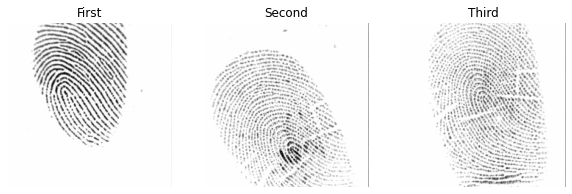

In [7]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,3, 1)
plt.imshow(images[0])
plt.axis('off')
plt.title("First")
fig.add_subplot(1,3, 2)
plt.imshow(images[1])
plt.axis('off')
plt.title("Second")
fig.add_subplot(1,3,3)
plt.imshow(images[2])
plt.axis('off')
plt.title("Third")

## (2) Image enhancement


### Method 1

In [8]:
def dft(img,k):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    f = np.fft.fft2(img)
    fshift = f*pow(np.abs(f),k) 
    img_back = np.fft.ifft2(fshift)
    img_back = np.real(img_back)
    img_back = img_back.astype(np.uint8)
    return img_back

In [9]:
dft1 = dft(images[0],0.03)
dft2 = dft(images[1],0.03)
dft3 = dft(images[2],0.03)

Text(0.5, 1.0, 'Third')

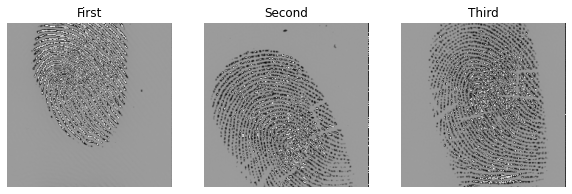

In [10]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)
plt.imshow(dft1,cmap='gray')
plt.axis('off')
plt.title("First")
fig.add_subplot(1,3, 2)
plt.imshow(dft2,cmap='gray')
plt.axis('off')
plt.title("Second")
fig.add_subplot(1,3,3)
plt.imshow(dft3,cmap='gray')
plt.axis('off')
plt.title("Third")

In [11]:
def histEqualization(img):
    im = img.copy()
    size = im.shape[0]*im.shape[1]
    cdf = np.zeros(256)
    for i in range(0,256):
        cdf[i]=np.round((np.count_nonzero(im<=i)/size)*255)
    
    im = cdf[im]
    im = im.astype(np.uint8)
    return im

In [12]:
hist_img1 = histEqualization(dft1)
hist_img2 = histEqualization(dft2)
hist_img3 = histEqualization(dft3)

Text(0.5, 1.0, 'Third')

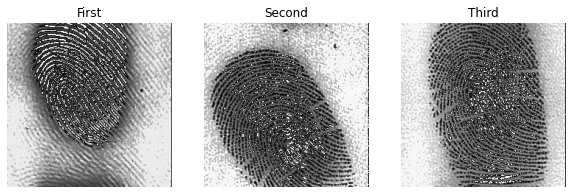

In [13]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)
plt.imshow(hist_img1,cmap='gray')
plt.axis('off')
plt.title("First")
fig.add_subplot(1,3, 2)
plt.imshow(hist_img2,cmap='gray')
plt.axis('off')
plt.title("Second")
fig.add_subplot(1,3,3)
plt.imshow(hist_img3,cmap='gray')
plt.axis('off')
plt.title("Third")

### Method 2

In [14]:
# Loads an RGB image from given path
def loadImage(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255

# Converts RGB image to grayscale
def getGrayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Extracts YUV components from an RGB image
def RGB2YUV(im):
    convMat = np.array([
        [ 0.299,  0.587,  0.114],
        [-0.147, -0.289,  0.436],
        [ 0.615, -0.515, -0.100],
    ])
    compExtr = np.array([
        im[:, :, 0], 
        im[:, :, 1], 
        im[:, :, 2],
    ])

    p, n, m = compExtr.shape
    ret = np.zeros((p, n, m))
    for i in range(p):
        for k in range(p):
            ret[i] += np.multiply(convMat[i][k], compExtr[k])

    return ret[0], ret[1], ret[2]

# Applies guided filter onto 'im' with window-size 'Ws' and smoothing parameter 'e'
def guidedFilter(im, guide, Ws, e):
    imMean = cv2.blur(im, (Ws, Ws))
    guideMean = cv2.blur(guide, (Ws, Ws))
    imVar = cv2.blur(guide ** 2, (Ws, Ws)) - (guideMean ** 2)

    a = cv2.blur(im * guide, (Ws, Ws)) - imMean * guideMean
    a = a / (imVar + e)
    b = imMean - a * guideMean

    aMean = cv2.blur(a, (Ws, Ws))
    bMean = cv2.blur(b, (Ws, Ws))
    
    return (aMean * guide + bMean)

# Finds the window size as specified in the paper
def findWindowSize(im):
    m = np.min(im.shape) // 4
    return m + (1 & ~m)

# Mean filter for testing
def meanFilter(im):
    return cv2.blur(Y,(findWindowSize(Y)//10,findWindowSize(Y)//10))

# Gaussian filter for testing
def gaussianFilter(im):
    return cv2.GaussianBlur(im, (findWindowSize(Y)//5,findWindowSize(Y)//5), 0)

# Performs local gamma transform given filtered g
def localGammaTransform(im, g):
    return (im) ** ((g + 2) ** (2 * g - 1))

# Stretch range from [A, B] to [A, 1]
def linearStretching(im):
    lMax = np.max(im)
    lMin = np.min(im)
    return ((1 - lMin) * im + (lMax - 1) * lMin) / (lMax - lMin)

# Converts YUV to RGB
def YUV2RGB(im):
    convMat = np.array([
        [ 1.000,  0.000,  1.140],
        [ 1.000, -0.395, -0.581],
        [ 1.000,  2.032,  0.001],
    ])

    p, n, m = im.shape
    ret = np.zeros((p, n, m))
    for i in range(p):
        for k in range(p):
            ret[i] += np.multiply(convMat[i][k], im[k])

    return ret[0], ret[1], ret[2]

# Applies color compensation to ensure consistent saturation of output image
def colorCompensation(im, Y, newY, e):
    return np.where(Y == 0.0, im, e * (((newY / Y) * (im + Y)) + im - Y))
    
# Clip values of image to be between 0 and 1
def inRange(im):
    return np.minimum(1, np.maximum(im, 0))

In [15]:
def skeletonize(img):
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))


    while True:
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(img, open)
 
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        if cv2.countNonZero(img)==0:
            break
    return skel
    

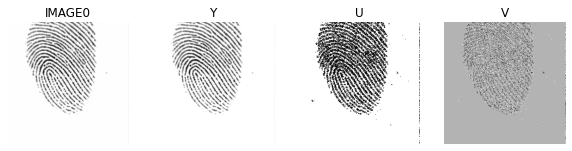

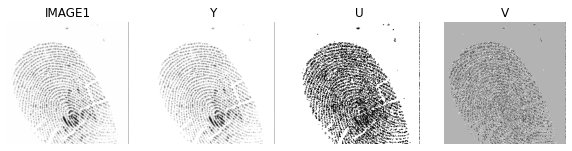

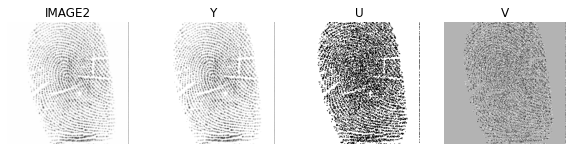

In [16]:
for i in range(0,3):
    imYUV = RGB2YUV(images[i]/255)
    Y, U, V = imYUV
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1,4, 1)
    plt.imshow(images[i],cmap='gray')
    plt.axis('off')
    plt.title("IMAGE"+str(i))
    fig.add_subplot(1,4, 2)
    plt.imshow(Y,cmap='gray')
    plt.axis('off')
    plt.title("Y")
    fig.add_subplot(1,4, 3)
    plt.imshow(U,cmap='gray')
    plt.axis('off')
    plt.title("U")
    fig.add_subplot(1,4,4)
    plt.imshow(V,cmap='gray')
    plt.axis('off')
    plt.title("V")

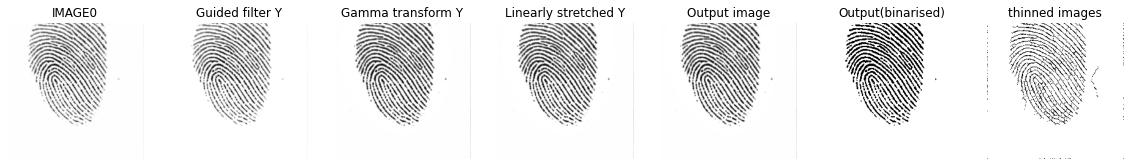

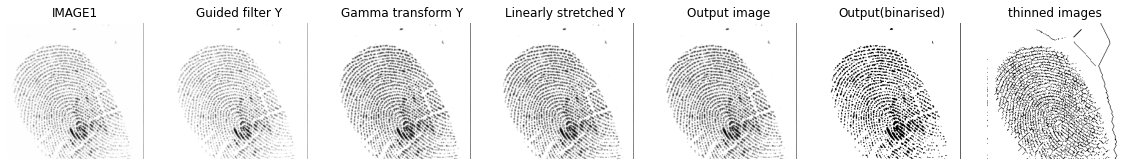

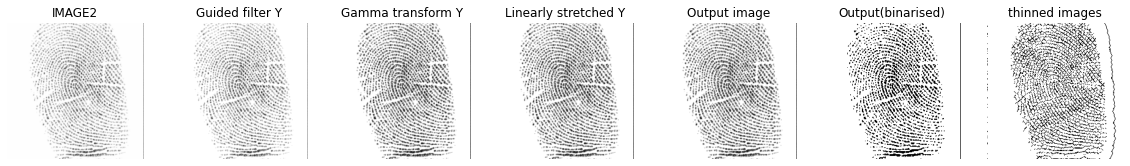

In [17]:
output_images = []
final_images = []
for j in range(0,3):
    imYUV = RGB2YUV(images[j]/255)
    Y, U, V = imYUV
    g = Y.copy()
    for i in range(1):
        g = guidedFilter(Y, g, findWindowSize(Y), np.std(g))
    gF = g
    fig = plt.figure(figsize=(20, 10))
    fig.add_subplot(1,7, 1)
    plt.imshow(images[j],cmap='gray')
    plt.axis('off')
    plt.title("IMAGE"+str(j))
    fig.add_subplot(1,7, 2)
    plt.imshow(Y,cmap='gray')
    plt.axis('off')
    plt.title("Guided filter Y")
    gY = localGammaTransform(Y, gF)
    fig.add_subplot(1,7, 3)
    plt.imshow(gY, cmap = "gray")
    plt.axis('off')
    plt.title("Gamma transform Y")
    fig.add_subplot(1,7, 4)
    lY = linearStretching(gY)
    plt.imshow(lY, cmap = "gray")
    plt.axis('off')
    plt.title("Linearly stretched Y")
    fig.add_subplot(1,7, 5)
    RGB = YUV2RGB(np.array([lY, U, V]))
    op_img = inRange(cv2.merge(RGB))
    output_images.append(op_img)
    plt.imshow(lY, cmap = "gray")
    plt.axis('off')
    plt.title("Output image")
    im2 = inRange(cv2.merge(RGB))
    (row, col) = im2.shape[0:2]
    im_m2 = np.zeros((row, col))
    for i in range(row):
        for j in range(col):
            im_m2[i, j] = sum(im2[i, j]) * 0.33
    im_m2 = np.where(im_m2>0.6,1,0)      
    fig.add_subplot(1,7, 6)
    plt.imshow(im_m2,cmap='gray')
    plt.axis('off')
    plt.title("Output(binarised)")
    
    fig.add_subplot(1,7,7)
    im_s = skeletonize(im_m2.astype(np.uint8))
    plt.imshow(1-im_s,cmap='gray')
    plt.axis('off')
    plt.title("thinned images")
    final_images.append(im_s)

### (3) Binarization 


### Method 1

Text(0.5, 1.0, 'Third')

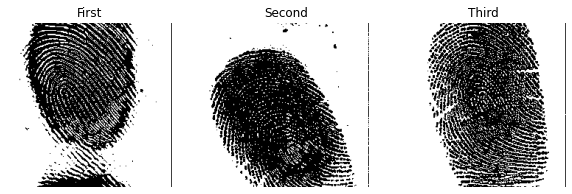

In [18]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)
img_b1 = np.where(hist_img1>120,1,0)
plt.imshow(img_b1,cmap='gray')
plt.axis('off')
plt.title("First")
fig.add_subplot(1,3, 2)
img_b2 = np.where(hist_img2>120,1,0)
plt.imshow(img_b2,cmap='gray')
plt.axis('off')
plt.title("Second")
fig.add_subplot(1,3,3)
img_b3 = np.where(hist_img3>120,1,0)
plt.imshow(img_b3,cmap='gray')
plt.axis('off')
plt.title("Third")

### Method 2

### (4) Thinning 


In [19]:
img3_1 = skeletonize(img_b1.astype(np.uint8))

img3_2 = skeletonize(img_b2.astype(np.uint8))

img3_3 = skeletonize(img_b3.astype(np.uint8))

Text(0.5, 1.0, 'Third')

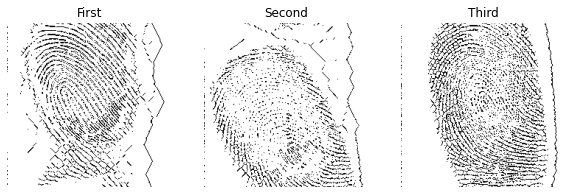

In [20]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)

plt.imshow(1-img3_1,cmap='gray')
plt.axis('off')
plt.title("First")
fig.add_subplot(1,3, 2)

plt.imshow(1-img3_2,cmap='gray')
plt.axis('off')
plt.title("Second")
fig.add_subplot(1,3,3)

plt.imshow(1-img3_3,cmap='gray')
plt.axis('off')
plt.title("Third")


### (5) Feature Extraction

In [21]:
def feature_extraction(img):
    total_feature_points = 0
    im = img.copy()
    for r in range(1,img.shape[0]-1):
      for c in range(1,img.shape[1]-1):
            sum = np.sum(img[r-1:r+2,c-1:c+2])-1
            if sum ==5 or sum == 7 or sum == 4:
                im[r][c]= 0
                total_feature_points +=1
            else:
                im[r][c]=255
    return im
                

In [22]:
features1 = feature_extraction(img3_1)
features2 = feature_extraction(img3_2)
features3 = feature_extraction(img3_3)

## Features using image enhancement - dft,histogram equaliation

Text(0.5, 1.0, 'feature 3')

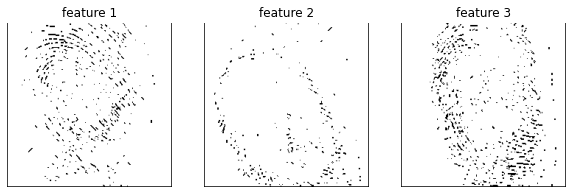

In [23]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)

plt.imshow(features1,cmap='gray')
plt.axis('off')
plt.title("feature 1")
fig.add_subplot(1,3, 2)

plt.imshow(features2,cmap='gray')
plt.axis('off')
plt.title("feature 2")
fig.add_subplot(1,3,3)
plt.imshow(features3,cmap='gray')
plt.axis('off')
plt.title("feature 3")

## Features using weak light image enhancement

In [24]:
features1 = feature_extraction(final_images[0])
features2 = feature_extraction(final_images[1])
features3 = feature_extraction(final_images[2])

Text(0.5, 1.0, 'feature 3')

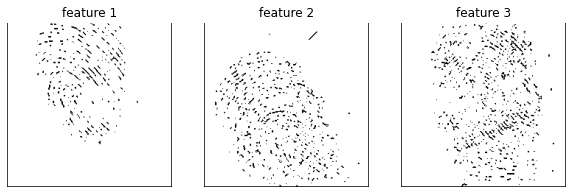

In [25]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,3, 1)

plt.imshow(features1,cmap='gray')
plt.axis('off')
plt.title("feature 1")
fig.add_subplot(1,3, 2)

plt.imshow(features2,cmap='gray')
plt.axis('off')
plt.title("feature 2")
fig.add_subplot(1,3,3)
plt.imshow(features3,cmap='gray')
plt.axis('off')
plt.title("feature 3")